# 3.0-Normalization and Embedding 

**Inés Sentís**

Date of execution 

In [1]:
Sys.Date()

[1] "2025-01-09"

## Introduction

Normalize data and create embeddings for each time point fraction

In [2]:
timepoint <- "T2"

## Libraries

In [3]:
suppressMessages(suppressWarnings({
library(Seurat)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggplot2)
library(harmony)
library(scater) 
library(scran)
}))

## Parameters

In [4]:
#here::dr_here(show_reason = TRUE)
source(here::here("SCGRES_83_84/sc_analysis/misc/paths.R"))

"{clust}/{plt_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

"{clust}/{robj_dir}" %>%
  glue::glue() %>%
  here::here() %>%
  dir.create(path = .,
           showWarnings = FALSE,
           recursive = TRUE)

set.seed(0)

## Load data

In [5]:
seurat_obj <- readRDS(here::here(glue::glue("{qc}/{robj_dir}/clean_combined_object_{timepoint}.rds")))

In [6]:
head(seurat_obj@meta.data)

,orig.ident,nCount_RNA,nFeature_RNA,sample_org,timepoint,replicate,sample_id,pct_mt,percent.ribo,doublet_score,doublet_pred
,<chr>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>
T2_1_AAACCTGAGATATGGT-1,SCGRES_83_84,3994,1982,OS0017_1,T2,1,T2_1,3.730596,8.037056,0.025334046,FALSE
T2_1_AAACCTGAGCGTTGCC-1,SCGRES_83_84,6217,2019,OS0017_1,T2,1,T2_1,2.010616,27.344378,0.011166855,FALSE
T2_1_AAACCTGAGCTAGGCA-1,SCGRES_83_84,10651,3189,OS0017_1,T2,1,T2_1,2.591306,19.453572,0.076398636,FALSE
T2_1_AAACCTGAGCTGAAAT-1,SCGRES_83_84,3560,1811,OS0017_1,T2,1,T2_1,2.640449,12.191011,0.007583643,FALSE
T2_1_AAACCTGAGGGTGTGT-1,SCGRES_83_84,1131,568,OS0017_1,T2,1,T2_1,1.768347,1.237843,0.008423769,FALSE
T2_1_AAACCTGAGTGAATTG-1,SCGRES_83_84,5681,2317,OS0017_1,T2,1,T2_1,7.657103,15.120577,0.017482194,FALSE


## Normalization and linear dimensional reduction

In [7]:
seurat_obj <- NormalizeData(
  seurat_obj,
  normalization.method = "LogNormalize",
  scale.factor = 1e4
)

In [8]:
sce <- as.SingleCellExperiment(seurat_obj)
sce

class: SingleCellExperiment 
dim: 29866 31010 
metadata(0):
assays(2): counts logcounts
rownames(29866): AL627309.1 AL627309.5 ... AC010086.3 TTTY17C
rowData names(0):
colnames(31010): T2_1_AAACCTGAGATATGGT-1 T2_1_AAACCTGAGCGTTGCC-1 ...
  T2_2_TTTGTCATCTCGTTTA-1 T2_2_TTTGTCATCTTATCTG-1
colData names(12): orig.ident nCount_RNA ... doublet_pred ident
reducedDimNames(0):
mainExpName: RNA
altExpNames(0):

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


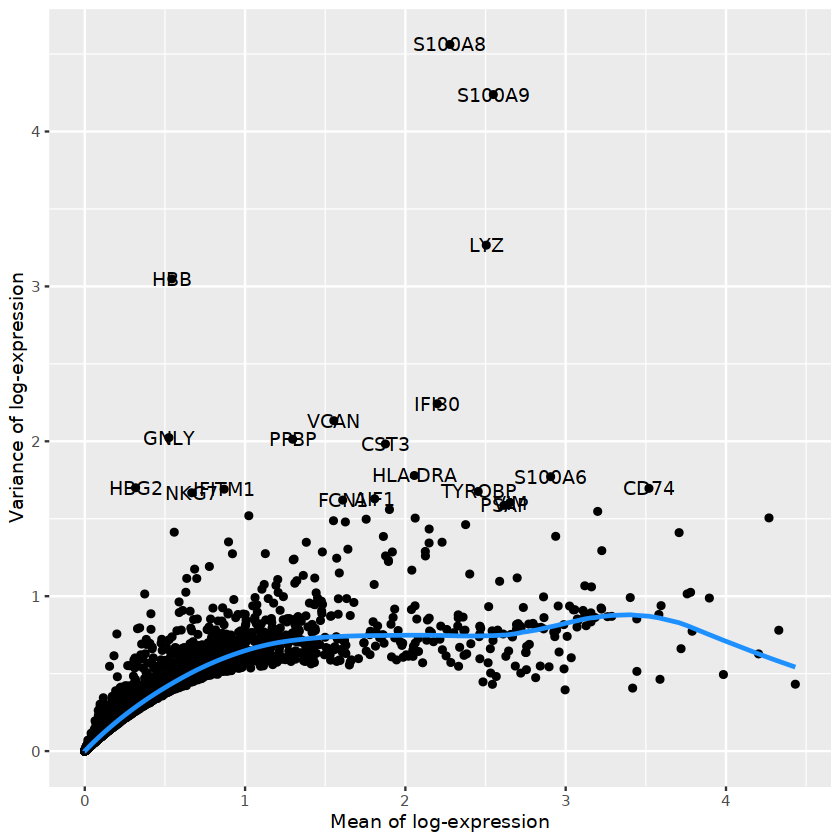

In [9]:
gene_var <- modelGeneVar(sce)

tops <- gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

gene_var %>% 
  as.data.frame() %>% 
  ggplot(aes(mean, total)) +
  geom_point() +
  geom_line(aes(y = tech), colour = "dodgerblue", size = 1) +
  labs(x = "Mean of log-expression", y = "Variance of log-expression")+
  geom_text(data=tops, aes(mean,total,label=rownames(tops)))

In [10]:
gene_var %>% 
    as.data.frame() %>% 
    arrange(desc(total)) %>% 
    head(n=20)

,mean,total,tech,bio,p.value,FDR
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
S100A8,2.2776370,4.561829,0.7451123,3.8167166,3.663408e-173,5.411952e-169
S100A9,2.5483668,4.238541,0.7455990,3.4929422,3.189492e-145,1.884735e-141
LYZ,2.5045874,3.266020,0.7442274,2.5217923,4.818563e-77,1.016923e-73
HBB,0.5434068,3.048381,0.4362117,2.6121694,8.750818e-236,2.585517e-231
IFI30,2.1992153,2.242475,0.7469510,1.4955235,3.127504e-28,1.642112e-25
VCAN,1.5536300,2.132960,0.7383572,1.3946026,2.444926e-25,1.111350e-22
GNLY,0.5248525,2.023603,0.4249553,1.5986478,1.890885e-94,5.586808e-91
PPBP,1.2968183,2.013138,0.7145566,1.2985813,1.338806e-23,5.903935e-21
CST3,1.8754327,1.982711,0.7464996,1.2362110,6.442115e-20,2.265937e-17


In [11]:
hvgs <- getTopHVGs(gene_var,fdr.threshold = 0.05)
length(hvgs)

[1] 587

In [12]:
# remove TCR genes
hvgs <- hvgs[!grepl("^TR[ABDG][VJC]", hvgs)]

# remove hemoglobin genes
hvgs <- hvgs[!grepl("HBA[12]|HBB|HBD|HBG[12]", hvgs)]
length(hvgs)

[1] 502

In [13]:
seurat_obj <- seurat_obj %>%
  ScaleData(features=hvgs) %>% 
  RunPCA(features=hvgs)

Centering and scaling data matrix

PC_ 1 
Positive:  IFI30, AIF1, FTL, LYZ, FCN1, CTSS, PSAP, LST1, S100A9, SERPINA1 
	   S100A6, NAMPT, CST3, S100A11, MNDA, LYN, VCAN, S100A8, HLA-DRA, VIM 
	   TYROBP, HLA-DRB1, ARHGAP26, CDKN1A, ZEB2, SAT1, HLA-DQB1, WARS, CD14, NEAT1 
Negative:  CD247, SKAP1, IFITM1, IL32, CD7, PRKCH, GZMA, IL2RG, CD69, ZAP70 
	   PRF1, SYNE2, CTSW, SLC38A1, CST7, CD96, GNLY, IL2RB, NKG7, GZMM 
	   KLRB1, SAMD3, ETS1, PYHIN1, KLRK1, STAT4, LCK, GZMB, PCED1B-AS1, TENT5C 
PC_ 2 
Positive:  GP9, TMEM40, TUBB1, MPIG6B, GP1BA, CMTM5, GNG11, PTCRA, ACRBP, CAVIN2 
	   ITGA2B, PF4, ITGB3, LY6G6F, PPBP, TUBA4A, GRAP2, SPARC, RGS18, TREML1 
	   MYLK, C19orf33, TSC22D1, CLU, ALOX12, RAB27B, STON2, LTBP1, GUCY1B1, MYL9 
Negative:  MALAT1, CD74, S100A4, CRIP1, S100A6, S100A11, JUNB, TYROBP, VIM, HLA-DRB1 
	   HLA-DRA, CD52, S100A10, HLA-DPA1, IFITM3, HLA-DPB1, CTSS, LGALS1, ANXA1, NEAT1 
	   HLA-DQB1, LYN, LST1, IFI30, AIF1, WARS, ZEB2, NAMPT, FCGR3A, SERPINA1 
PC_ 3 
Positive: 

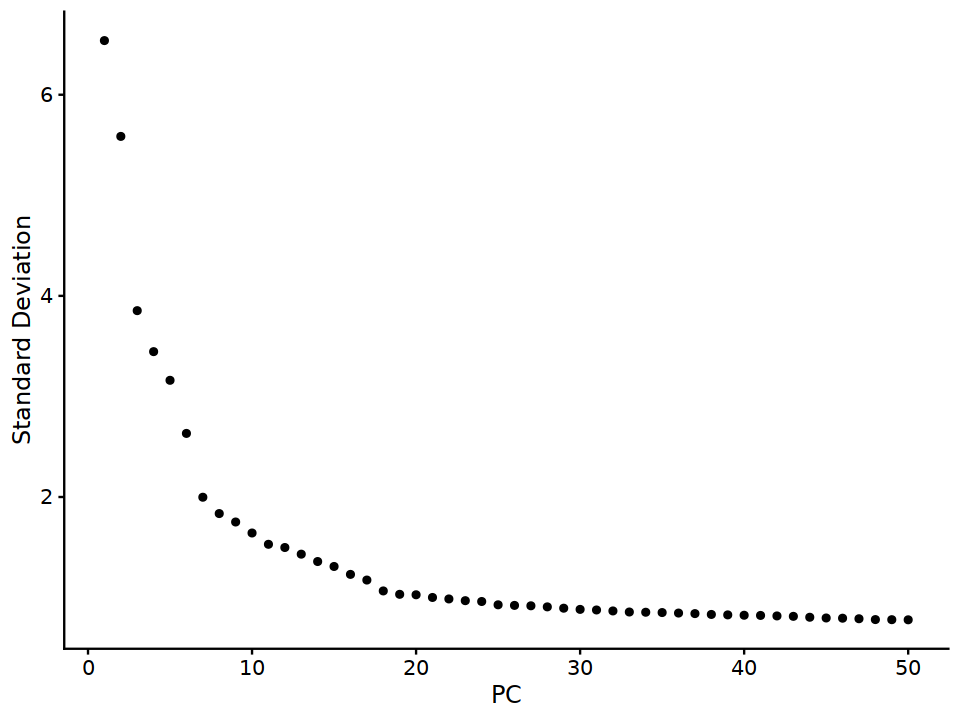

In [14]:
options(repr.plot.width = 8, repr.plot.height = 6)
ElbowPlot(seurat_obj, n=50)

In [15]:
ProjectDim(seurat_obj, reduction = "pca")

PC_ 1 
Positive:  IFI30, AIF1, FTL, LYZ, FCN1, CTSS, PSAP, LST1, S100A9, SERPINA1 
	   S100A6, NAMPT, CST3, S100A11, MNDA, LYN, VCAN, S100A8, HLA-DRA, VIM 
Negative:  CD247, SKAP1, IFITM1, IL32, CD7, PRKCH, GZMA, IL2RG, CD69, ZAP70 
	   PRF1, SYNE2, CTSW, SLC38A1, CST7, CD96, GNLY, IL2RB, NKG7, GZMM 
PC_ 2 
Positive:  GP9, TMEM40, TUBB1, MPIG6B, GP1BA, CMTM5, GNG11, PTCRA, ACRBP, CAVIN2 
	   ITGA2B, PF4, ITGB3, LY6G6F, PPBP, TUBA4A, GRAP2, SPARC, RGS18, TREML1 
Negative:  MALAT1, CD74, S100A4, CRIP1, S100A6, S100A11, JUNB, TYROBP, VIM, HLA-DRB1 
	   HLA-DRA, CD52, S100A10, HLA-DPA1, IFITM3, HLA-DPB1, CTSS, LGALS1, ANXA1, NEAT1 
PC_ 3 
Positive:  NKG7, GNLY, PRF1, CCL5, GZMA, CST7, KLRD1, NEAT1, CTSW, IL2RB 
	   TYROBP, KLRK1, ARHGAP26, S100A4, CCL4, KLRC1, IFITM3, KLRF1, ANXA1, FGFBP2 
Negative:  LILRA4, JCHAIN, CLEC4C, NIBAN3, SERPINF1, DERL3, MZB1, ITM2C, AC023590.1, LINC01478 
	   LINC01374, TCF4, IGKC, TPM2, AFF3, RGS7, AHSP, SLC4A1, ALAS2, SELENBP1 
PC_ 4 
Positive:  AHSP, ALAS2, 

An object of class Seurat 
29866 features across 31010 samples within 1 assay 
Active assay: RNA (29866 features, 0 variable features)
 1 dimensional reduction calculated: pca

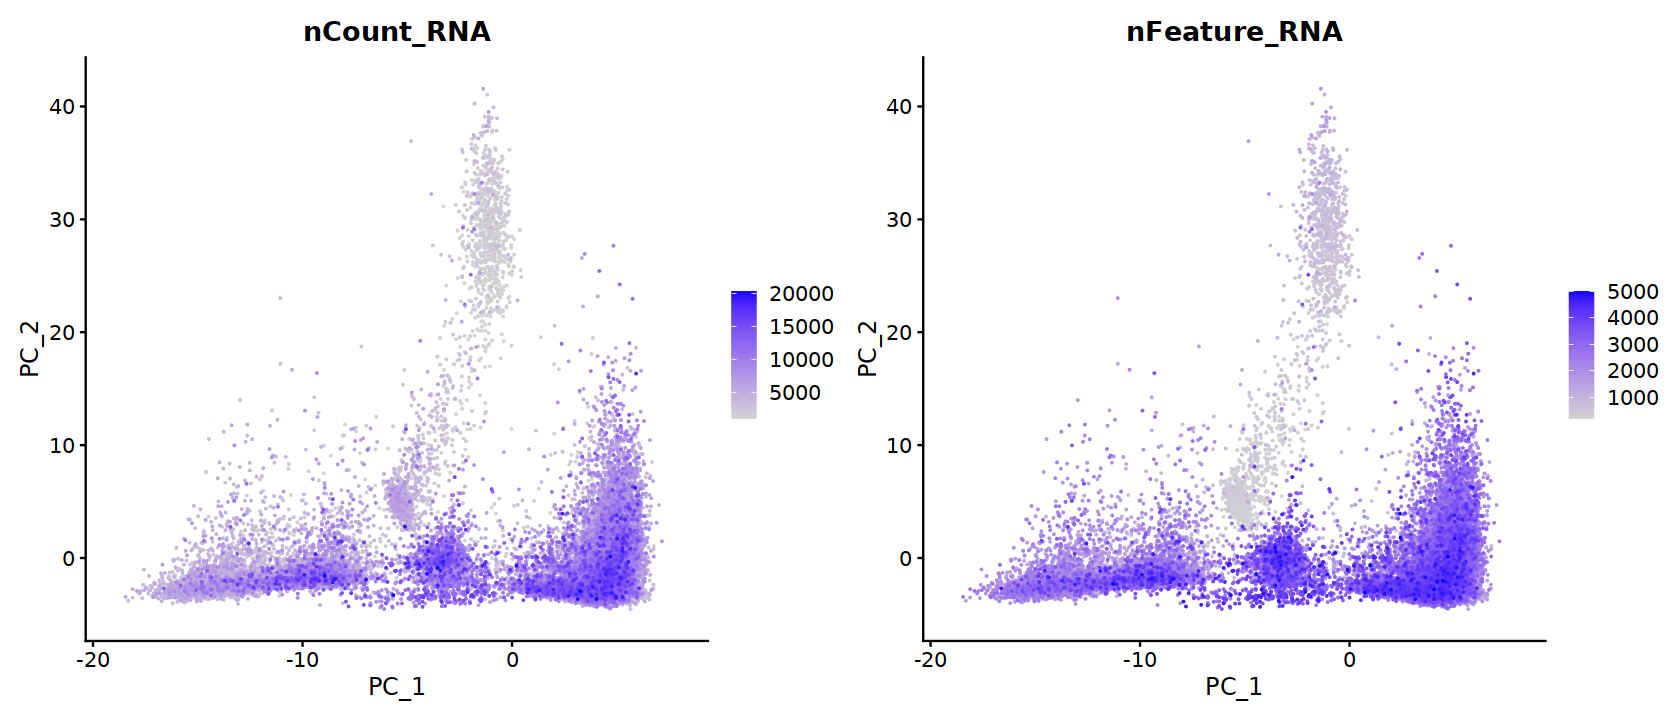

In [16]:
options(repr.plot.width = 14, repr.plot.height = 6)
FeaturePlot(object = seurat_obj, reduction = "pca",
        features = c("nCount_RNA","nFeature_RNA"), order=T)

## UMAP representation

In [17]:
comp=20

In [18]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "pca",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
11:05:02 UMAP embedding parameters a = 0.9922 b = 1.112

11:05:02 Read 31010 rows and found 20 numeric columns

11:05:02 Using Annoy for neighbor search, n_neighbors = 30

11:05:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:05:05 Writing NN index file to temp file /scratch_tmp/33937378/RtmppbkRy1/file5b765801ad6e

11:05:05 Searching Annoy index using 1 thread, search_k = 3000

11:05:16 Annoy recall = 100%

11:05:16 Commencing smooth kNN distance calibration using 1 thread
 with ta

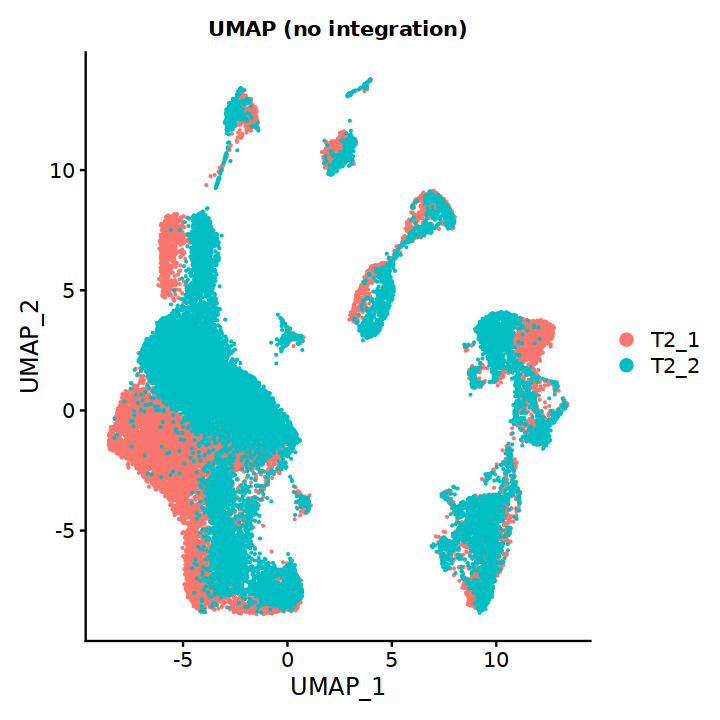

In [19]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

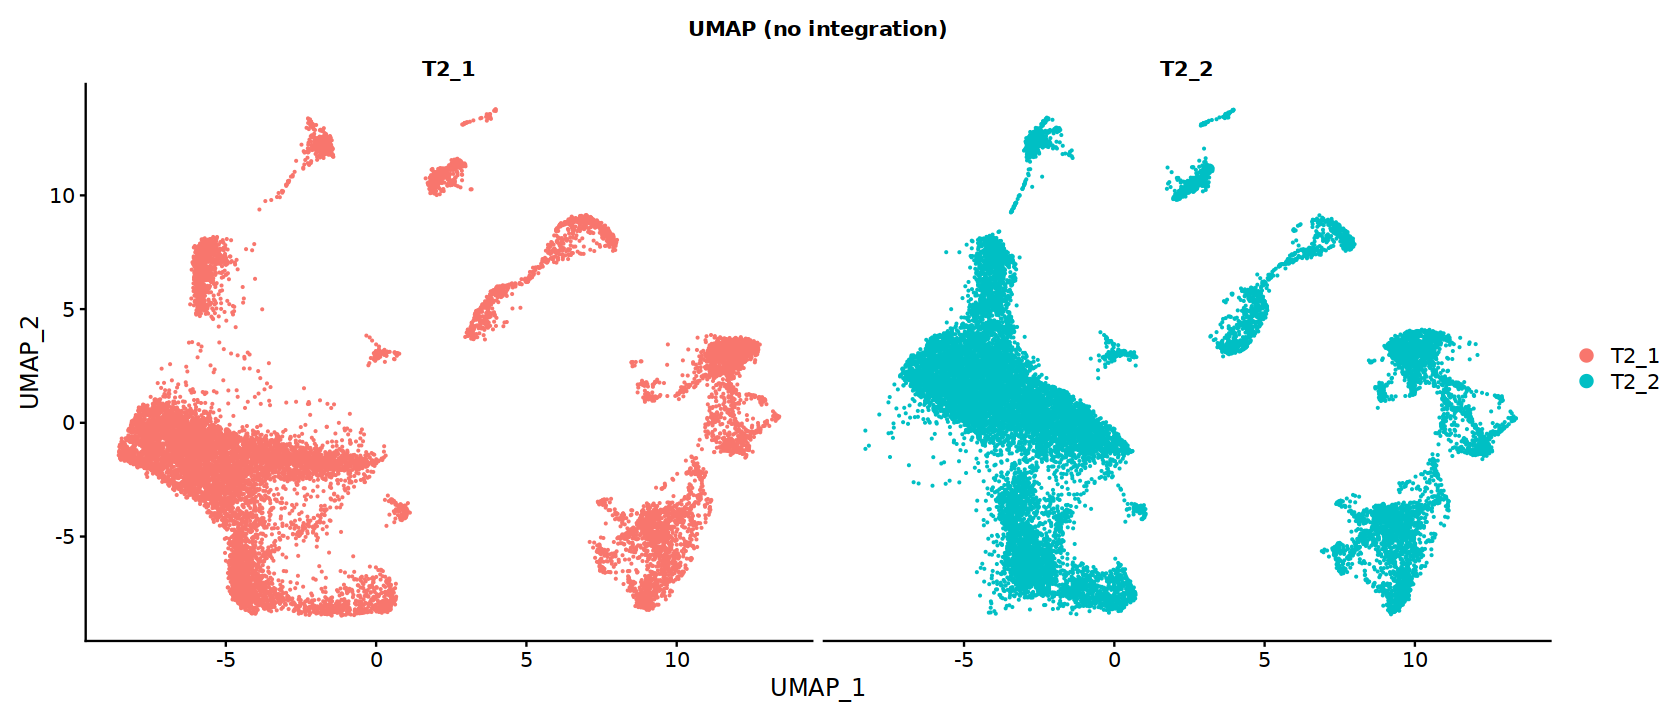

In [20]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (no integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## Integration with Harmony

In [21]:
# make a copy of the PCA reduction
seurat_obj@reductions$pca_filt <- seurat_obj@reductions$pca

# Filter to the desired number of components according to elbow
seurat_obj@reductions$pca_filt@cell.embeddings <- seurat_obj@reductions$pca_filt@cell.embeddings[, c(1:comp)]
seurat_obj@reductions$pca_filt@feature.loadings <- seurat_obj@reductions$pca_filt@feature.loadings[, c(1:comp)]

In [22]:
seurat_obj <- RunHarmony(
  object = seurat_obj,
  reduction = "pca_filt",
  group.by.vars = "sample_id",
  assay.use = "RNA",
  project.dim = FALSE,
  reduction.save = "harmony"
)

Transposing data matrix

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



In [23]:
seurat_obj <- RunUMAP(
  seurat_obj,
  dims = 1:comp,
  reduction = "harmony",
  reduction.name = "umap",
  reduction.key = "UMAP_"
)

11:06:21 UMAP embedding parameters a = 0.9922 b = 1.112

11:06:21 Read 31010 rows and found 20 numeric columns

11:06:21 Using Annoy for neighbor search, n_neighbors = 30

11:06:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:06:24 Writing NN index file to temp file /scratch_tmp/33937378/RtmppbkRy1/file5b767dcc826f

11:06:24 Searching Annoy index using 1 thread, search_k = 3000

11:06:34 Annoy recall = 100%

11:06:35 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

11:06:37 Initializing from normalized Laplacian + noise (using irlba)

11:06:38 Commencing optimization for 200 epochs, with 1337214 positive edges

11:07:12 Optimization finished



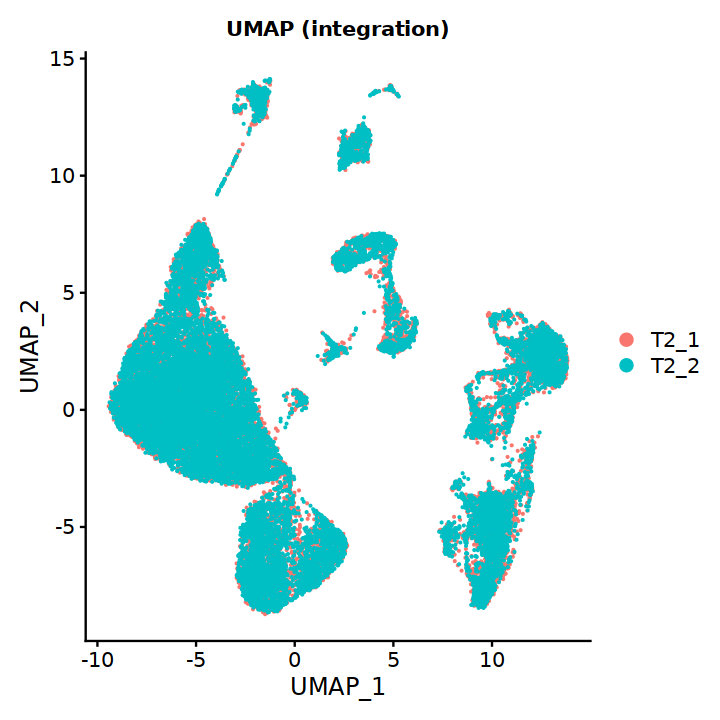

In [24]:
options(repr.plot.width = 6, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
     theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

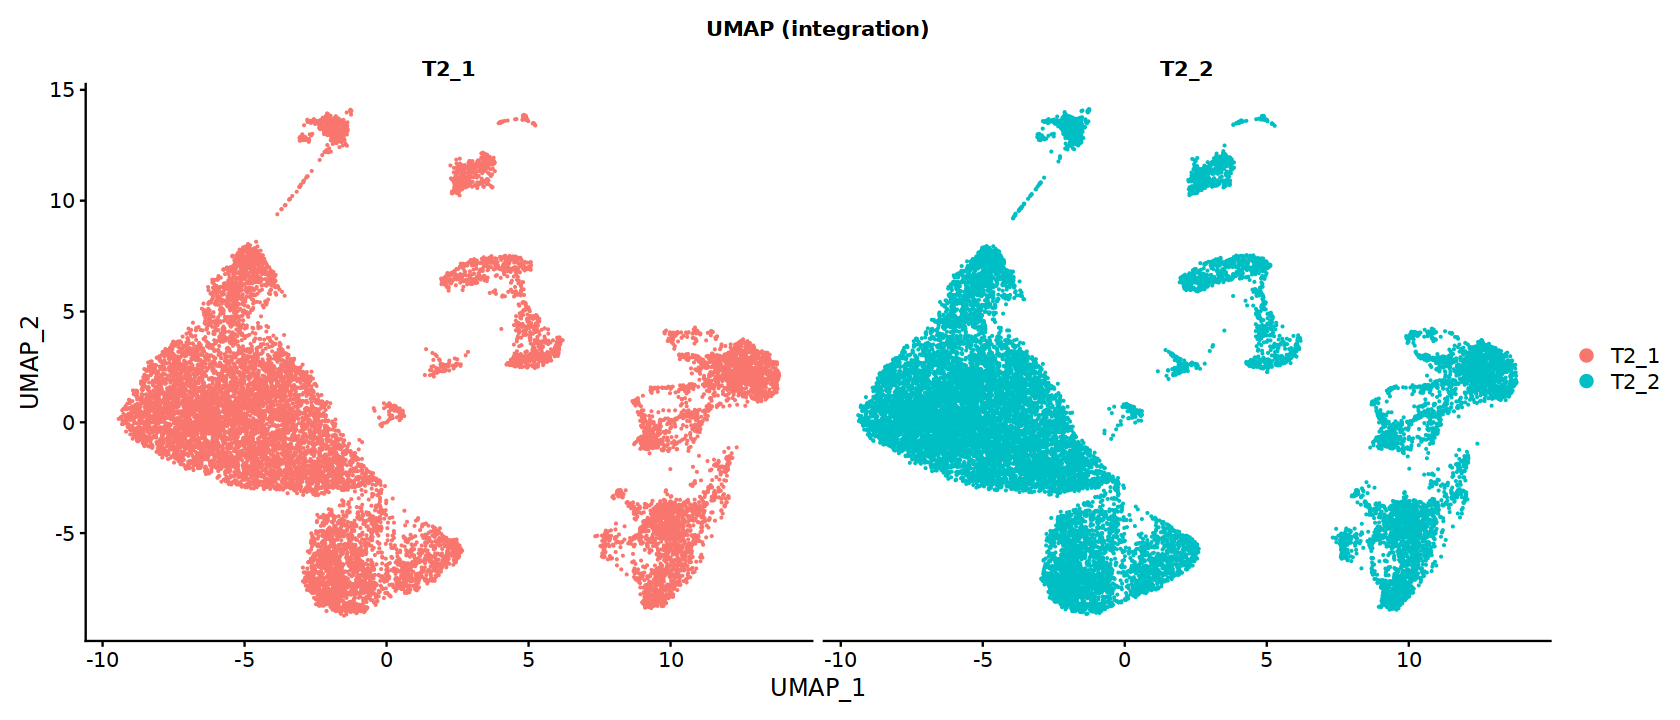

In [25]:
options(repr.plot.width = 14, repr.plot.height = 6, warn=-1,verbose = FALSE)
DimPlot(
  seurat_obj,
  reduction = "umap",
  group.by = "sample_id",
  split.by = "sample_id",
  pt.size = 0.1
) + ggtitle('UMAP (integration)') + 
    theme(plot.title = element_text(hjust = 0.5, size = 12, face = "bold"))

## More quality checks on UMAPs

### Compute Cell-Cycle Scores

In [26]:
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_obj <- CellCycleScoring(seurat_obj, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

### Plot several features

In [27]:
cat_vars <-c("Phase")
con_vars <- c("nCount_RNA", "nFeature_RNA", "pct_mt", "percent.ribo", 
              "doublet_score", "PTPRC", "HBM")
vars <- c(cat_vars, con_vars)

In [28]:
# compute plots
list_plots <- lapply(vars, function(var){
  if (var %in% cat_vars) {
      p <- DimPlot(seurat_obj, reduction = "umap", group.by=var)
  } else {
      p <- FeaturePlot(seurat_obj, reduction = "umap", feature=var, order = TRUE)
  }
  return(p)
})

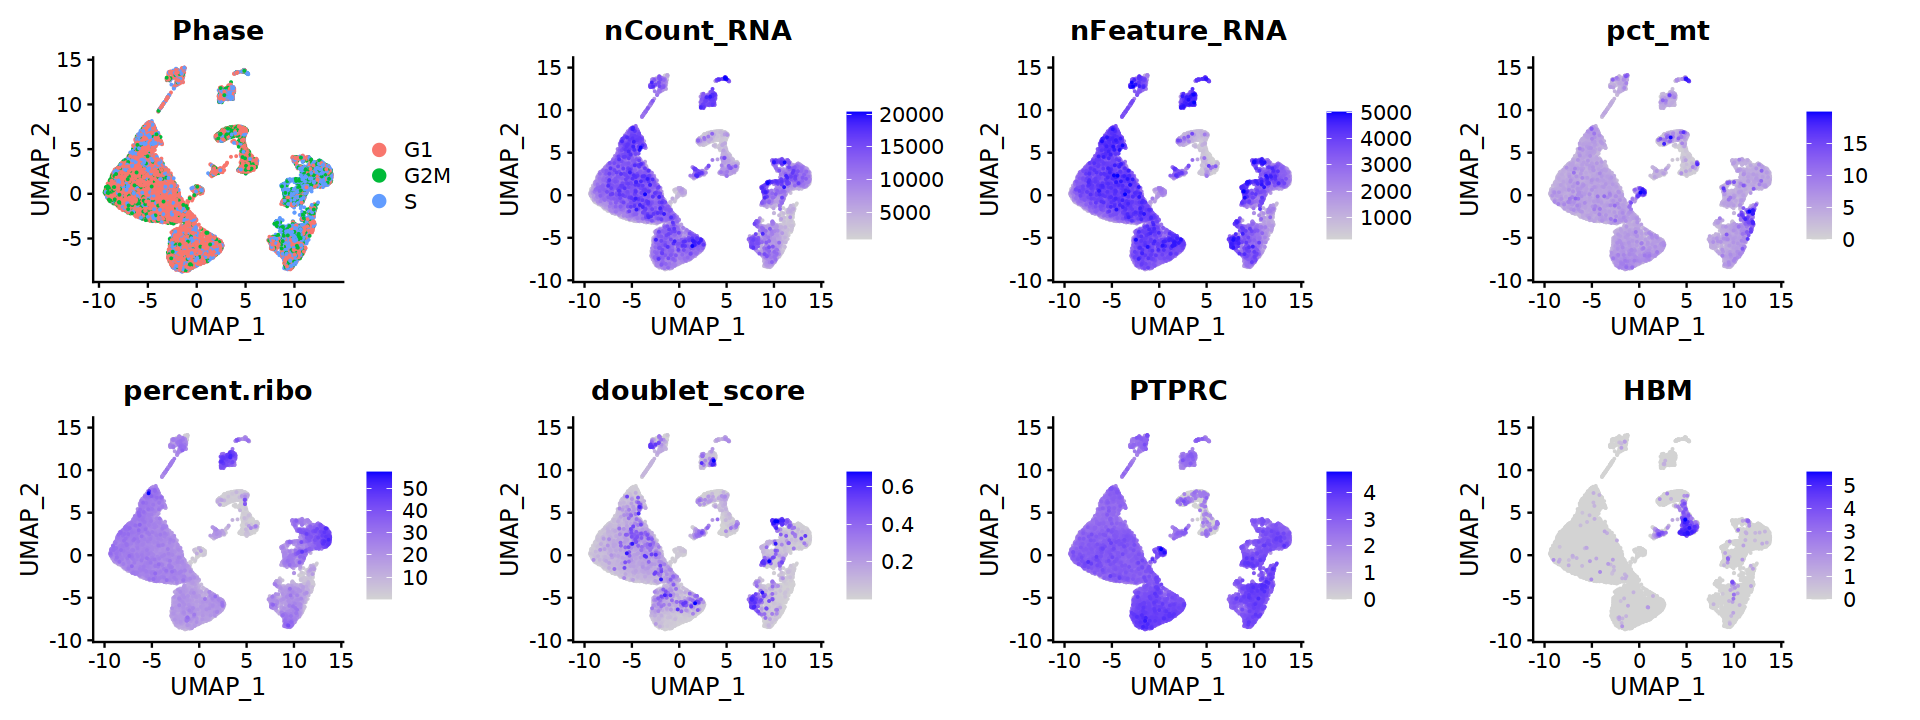

In [29]:
options(repr.plot.width = 16, repr.plot.height = 6, warn=-1,verbose = FALSE)
# show plots
cp <- cowplot::plot_grid(plotlist = list_plots,
                   align = "hv",
                   axis = "trbl",
                   ncol = 4,
                   nrow = 2)
cp

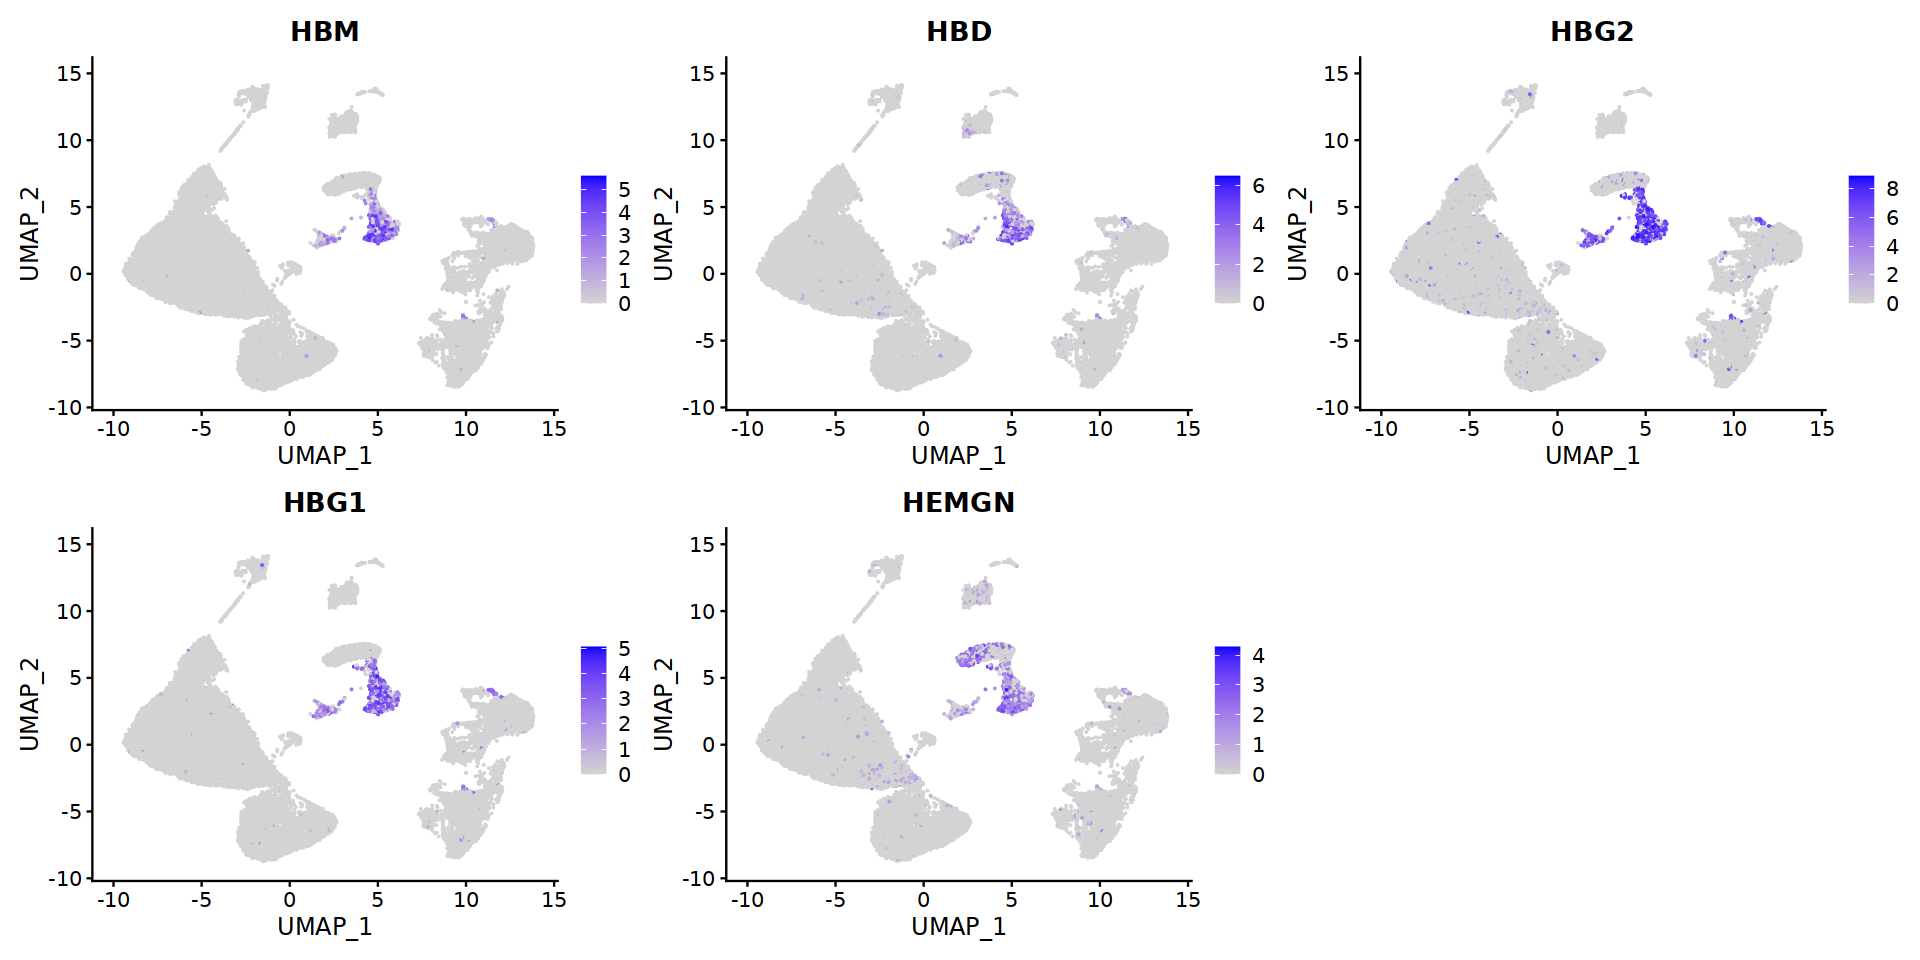

In [30]:
options(repr.plot.width = 16, repr.plot.height = 8, warn=-1,verbose = FALSE)
hemo_genes = c("HBM", "HBD", "HBG2","HBG1", "HEMGN")

FeaturePlot(seurat_obj, reduction = "umap", feature=hemo_genes, order = FALSE, ncol=3)

Erythrocytes need to be removed

# Save

In [31]:
saveRDS(seurat_obj, here::here(glue::glue("{clust}/{robj_dir}/dimred_combined_object_{timepoint}.rds")))

# Session Info

In [32]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/groups/singlecell/isentis/conda_envs/ines_r4.1.1c/lib/libopenblasp-r0.3.24.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=es_ES.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=es_ES.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=es_ES.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=es_ES.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] scran_1.22.1                scater_1.22.0              
 [3] scuttle_1.4.0               SingleCellExperiment_1.16.0
 [5] SummarizedExperiment_1.24.0 Biobase_2.54.0             
 [7] GenomicRanges_1.46.1        GenomeInfoDb_1.30.1        
 [9] IRanges_